# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [87]:
# Use the data folder provided in Tutorial 02 - Intro to Pandas.
DATA_FOLDER = 'Data/' 
EBOLA_FOLDER = DATA_FOLDER + 'ebola/'

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

In [79]:
import glob
import pandas as pd
import numpy as np
import os
import warnings

warnings.filterwarnings('ignore')

def import_from_forder(folder_path):
    allFiles = glob.glob(folder_path + '/*.csv')
    frame = pd.DataFrame()
    list_ = []

    for file_ in allFiles:
        df = pd.read_csv(file_, header=0)
        list_.append(df)
    frame = pd.concat(list_)
    return frame

# import the 3 subfolders
folders = [x[0] for x in os.walk(EBOLA_FOLDER)][1:]

# dataframes from 3 different folders
df1,df2,df3 = [import_from_forder(x) for x in folders]

# get same notation for the 3 dataframes and replace '-' by '0'
df1 = df1.rename(columns = {'Totals':'Guinea'}).replace(to_replace="-", value=0)
df2 = df2.rename(columns = {'Variable':'Description', 'National':'Liberia'}).replace(to_replace="-", value=0)
df3 = df3.rename(columns = {'date':'Date', 'variable':'Description', 'National':'Sierra Leon'}).replace(to_replace="-", value=0)

In [80]:
def filter_by_terms(df, terms, match=True):
    if match:
        return df.loc[df.Description.str.match('|'.join(terms))]
    else:
        return df.loc[df.Description.str.contains('|'.join(terms))]

# take the rows containing deaths and cases terms and changing description to 'death' and 'case'
# returns 2 dataframes
def separate_death_case(df, death_terms, case_terms):
    return1 = filter_by_terms(df, death_terms)
    return1.Description = return1.Description.map(lambda x : 'death')
    return2 = filter_by_terms(df, case_terms)
    return2.Description = return2.Description.map(lambda x : 'case')
    return return1,return2

# specific terms we chose to be meaningful
# we only consider confirmed new cases and confirmed new deaths
df1_death_terms = ['New deaths registered', 'New deaths registered today']
df1_case_terms = ['New cases of confirmed']
df2_death_terms = ['Newly reported deaths']
df2_case_terms = ['New case/s \(confirmed\)']
df3_death_terms = ['etc_new_deaths']
df3_case_terms = ['new_confirmed']
    
df1_death,df1_case = separate_death_case(df1, df1_death_terms, df1_case_terms)
df2_death,df2_case = separate_death_case(df2, df2_death_terms, df2_case_terms)
df3_death,df3_case = separate_death_case(df3, df3_death_terms, df3_case_terms)

# fill NaN in totals with the sum of the row
def to_numeric(df):
    return df.apply(pd.to_numeric, errors="ignore")

df1_death.Guinea = to_numeric(df1_death).Guinea.fillna(df1_death.drop(['Guinea']).sum(axis=1))
df1_case.Guinea = to_numeric(df1_case).Guinea.fillna(df1_case.drop(['Guinea']).sum(axis=1))

df2_death.Liberia = to_numeric(df2_death).Liberia.fillna(df2_death.drop(['Liberia']).sum(axis=1))
df2_case.Liberia = to_numeric(df2_case).Liberia.fillna(df2_case.drop(['Liberia']).sum(axis=1))

df3_death["Sierra Leon"] = to_numeric(df3_death)["Sierra Leon"].fillna(df3_death.drop(["Sierra Leon"]).sum(axis=1))
df3_case["Sierra Leon"] = to_numeric(df3_case)["Sierra Leon"].fillna(df3_case.drop(["Sierra Leon"]).sum(axis=1))

# list of all dataframes containing death and case terms
list_df = [df1_death, df1_case, df2_death, df2_case, df3_death, df3_case]

In [84]:
# concatenate the three dataframes and reorder columns
df = pd.concat(list_df)
df = df[['Date', 'Description', 'Guinea', 'Liberia', 'Sierra Leon']]

# cast right types
df.apply(pd.to_numeric, errors='ignore')
df.Date = pd.to_datetime(df.Date)

# groupe by date and description
# pd.set_option('precision',2)
# df.groupby([df.Description, df.Date.dt.to_period("M")]).mean().fillna('')

In [85]:
cases = df[df.Description == "case"]
cases.groupby([cases.Date.dt.to_period("M")]).mean().fillna('')

,Guinea,Liberia,Sierra Leon
Date,,,
2014-06,,2.14,
2014-07,,1.82,
2014-08,6.9,5.44,19
2014-09,6.7,6.17,34
2014-10,4,1.36,57
2014-11,,2.60,60
2014-12,,1928.33,33


In [86]:
deaths = df[df.Description == "death"]
deaths.groupby([deaths.Date.dt.to_period("M")]).mean().fillna('')

,Guinea,Liberia,Sierra Leon
Date,,,
2014-06,,2.00,
2014-07,,4.27,
2014-08,1.6,23.22,0
2014-09,1.8,36.04,0.97
2014-10,7.5,28.04,3.7
2014-11,,13.47,0.57
2014-12,,0.00,2.2


## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [23]:
# Write your answer here
import glob
from os.path import join
import pandas as pd

DATA_FOLDER        = 'Data/' 
MICROBIOME_FOLDER  = DATA_FOLDER + 'microbiome/'

microbiome_files   = glob.glob(join(MICROBIOME_FOLDER, 'MID*.xls'))
metadata           = pd.read_excel(join(MICROBIOME_FOLDER, 'metadata.xls'))

microbiome_df     = pd.concat([pd.read_excel(f,header=None, names = ['Microbe', 'Counts']).assign(Barcode=metadata.BARCODE[idx],Group=metadata.GROUP[idx],Sample = metadata.SAMPLE[idx]) for idx,f in enumerate(microbiome_files)] ,ignore_index=True).fillna('unknown')

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [24]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

In [58]:
# Write your answer here
titanic = pd.read_excel(DATA_FOLDER+'titanic.xls')
titanic.dropna(axis=1)

transformedTitanic = titanic

transformedTitanic.sex = transformedTitanic.sex.replace(0,'female')
transformedTitanic.sex = transformedTitanic['sex'].replace(1,'male')

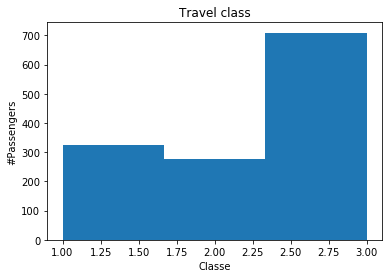

In [75]:
import matplotlib.pyplot as plt
import numpy as np


plt.hist(transformedTitanic.pclass,bins=3)
plt.title("Travel class")
plt.xlabel("Classe")
plt.ylabel("#Passengers")

plt.show()